<a href="https://colab.research.google.com/github/zacharyvunguyen/Linear-Risk-Model-for-Retinophathy-in-Diabetes-Patient/blob/main/Linear_Risk_Model_for_Retinophathy_in_Diabetes_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Linear Risk Model for Retinophathy in Diabetes Patients 

## Overview:

*Build a risk score model for retinopathy in diabetes patients using logistic regression.*

**Topics:**

- Data preprocessing
  - Log transformations
  - Standardization
- Basic Risk Models
  - Logistic Regression
  - C-index
  - Interactions Terms

## 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Mouting Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load Data

In [3]:
# For stability, load data from files that were generated using the load_data
X = pd.read_csv('/content/drive/MyDrive/0_data_science/ai_medical_prognosis/w1/X_data.csv',index_col=0)
y_df = pd.read_csv('/content/drive/MyDrive/0_data_science/ai_medical_prognosis/w1/y_data.csv',index_col=0)
y = y_df['y']

X and y are Pandas DataFrames that hold the data for 6,000 diabetic patients.

## 3. Explore the Dataset

The features (X) include the following fields:

* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)

We can use the head() method to display the first few records of each.

In [4]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [5]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Plot the histograms of each column of X_train below:

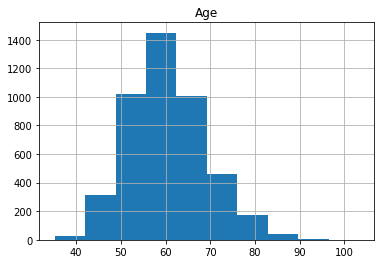

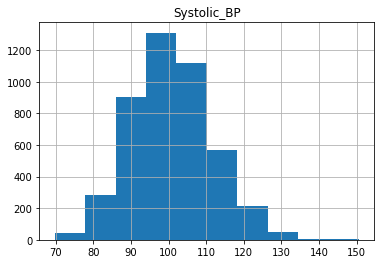

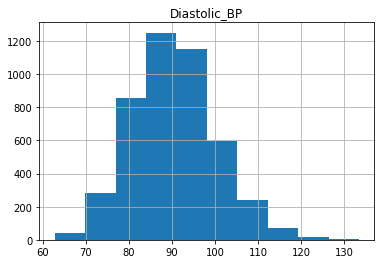

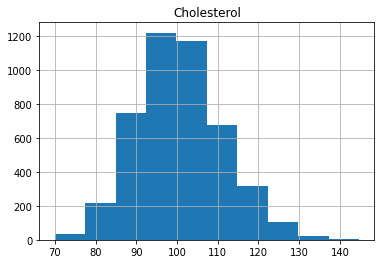

In [8]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.

Many statistical models assume that the data is normally distributed, forming a symmetric Gaussian bell shape (with no skew) more like the example below.

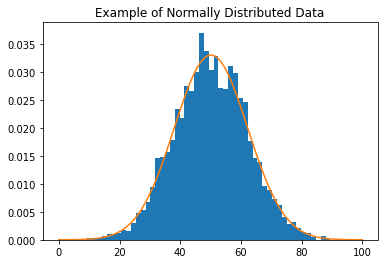

In [9]:
from scipy.stats import norm
data = np.random.normal(50,12, 5000)
fitting_params = norm.fit(data)
norm_dist_fitted = norm(*fitting_params)
t = np.linspace(0,100, 100)
plt.hist(data, bins=60, density=True)
plt.plot(t, norm_dist_fitted.pdf(t))
plt.title('Example of Normally Distributed Data')
plt.show()

We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data.

Let's plot the log of the feature variables to see that it produces the desired effect.

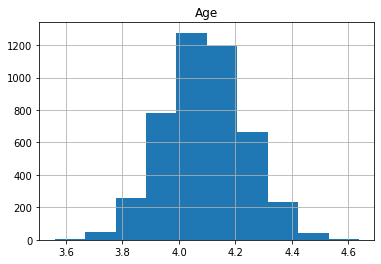

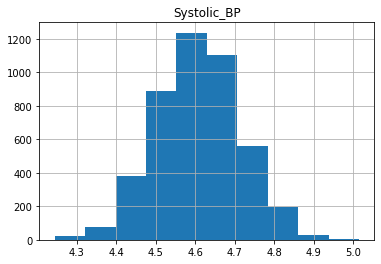

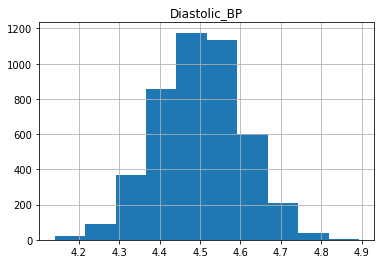

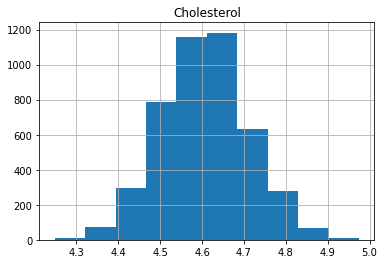

In [11]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

We can see that the data is more symmetric after taking the log.

## 4. Mean - Normalize the Data

Let's now transform our data so that the distributions are closer to standard normal distributions.

First we will remove some of the skew from the distribution by using the log transformation.
Then we will "standardize" the distribution so that it has a mean of zero and standard deviation of 1. Recall that a standard normal distribution has mean of zero and standard deviation of 1. 

In [12]:
def make_standard_normal(df_train, df_test): 
    # Remove skew by applying the log function to the train set, and to the test set
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    #calculate the mean and standard deviation of the training set
    mean = df_train_unskewed.mean(axis=0)
    stdev = df_train_unskewed.std(axis=0)
    
    # standardize the training set
    df_train_standardized = (df_train_unskewed - mean) / stdev
    
    # standardize the test set (see instructions and hints above)
    df_test_standardized = (df_test_unskewed - mean) / stdev
    
    return df_train_standardized, df_test_standardized

**Transform training and test data**

Use the function that you just implemented to make the data distribution closer to a standard normal distribution.

In [13]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

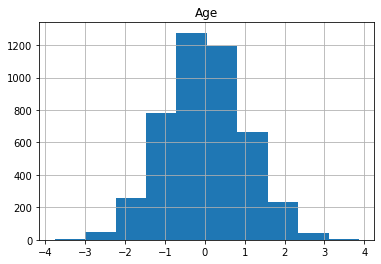

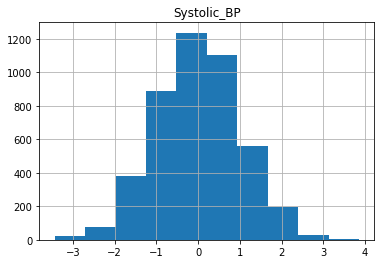

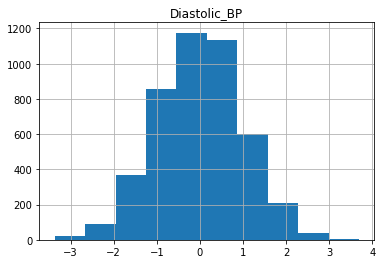

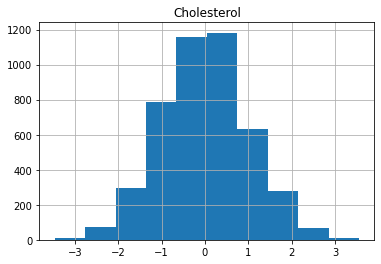

In [14]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

## 5. Build the Model

Implement the `lr_model` function to build a model using logistic regression with the `LogisticRegression` class from `sklearn`.

In [15]:
def lr_model(X_train, y_train):
    # import the LogisticRegression class
    from sklearn.linear_model import LogisticRegression
    
    # create the model object
    model = LogisticRegression()
    
    # fit the model to the training data
    model.fit(X_train, y_train)
    
    #return the fitted model
    return model

In [16]:
model_X = lr_model(X_train, y_train)

## 6. Evaluate the Model Using the C-index

* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.



In [17]:
def cindex(y_true, scores):
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    # use two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n): #choose the range of j so that j>i
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1

                # For permissible pairs, check if they are concordant or are ties

                # check for ties in the score
                if scores[i] == scores[j]:
                    # count the tie
                    ties += 1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier

                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier

    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + 0.5 * ties) / permissible
    
    return c_index

In [18]:
# test
y_true = np.array([1.0, 0.0, 0.0, 1.0])

# Case 1
scores = np.array([0, 1, 1, 0])
print('Case 1 Output: {}'.format(cindex(y_true, scores)))

# Case 2
scores = np.array([1, 0, 0, 1])
print('Case 2 Output: {}'.format(cindex(y_true, scores)))

# Case 3
scores = np.array([0.5, 0.5, 0.0, 1.0])
print('Case 3 Output: {}'.format(cindex(y_true, scores)))
cindex(y_true, scores)

Case 1 Output: 0.0
Case 2 Output: 1.0
Case 3 Output: 0.875


0.875

## 7. Evaluate the Model on the Test Set

In [19]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8182


Let's plot the coefficients to see which variables (patient features) are having the most effect. You can access the model coefficients by using `model.coef_`

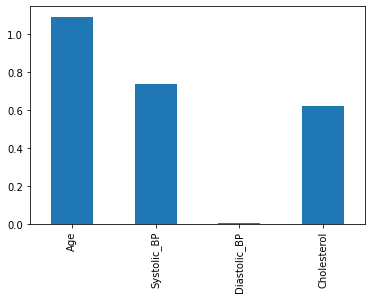

In [21]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

## 8. Improve the Model

You can try to improve your model by including interaction terms. 
* An interaction term is the product of two variables. 
    * For example, if we have data 
    $$ x = [x_1, x_2]$$
    * We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$

Add all interactions between every pair of variables to the training and test datasets. 

In [23]:
def add_interactions(X):
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    # 'i' loops through all features in the original dataframe X
    for i in range(m):
        
        # get the name of feature 'i'
        feature_i_name = features[i]
        
        # get the data for feature 'i'
        feature_i_data = X.loc[:, feature_i_name]
        
        # choose the index of column 'j' to be greater than column i
        for j in range(i+1, m):
            
            # get the name of feature 'j'
            feature_j_name = features[j]
            
            # get the data for feature j'
            feature_j_data = X.loc[:, feature_j_name]
            
            # create the name of the interaction feature by combining both names
            # example: "apple" and "orange" are combined to be "apple_x_orange"
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            
            # Multiply the data for feature 'i' and feature 'j'
            # store the result as a column in dataframe X_int
            X_int[feature_i_j_name] = feature_i_data * feature_j_data
        
    return X_int

In [24]:
## Testing 
print("Original Data")
print(X_train.loc[:, ['Age', 'Systolic_BP']].head())
print("Data w/ Interactions")
print(add_interactions(X_train.loc[:, ['Age', 'Systolic_BP']].head()))

Original Data
           Age  Systolic_BP
1824 -0.912451    -0.068019
253  -0.302039     1.719538
1114  2.576274     0.155962
3220  1.163621    -2.033931
2108 -0.446238    -0.054554
Data w/ Interactions
           Age  Systolic_BP  Age_x_Systolic_BP
1824 -0.912451    -0.068019           0.062064
253  -0.302039     1.719538          -0.519367
1114  2.576274     0.155962           0.401800
3220  1.163621    -2.033931          -2.366725
2108 -0.446238    -0.054554           0.024344


Make transformed version of X_train and X_test.

In [25]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

## 9. Evalute the Improved Model

In [26]:
model_X_int = lr_model(X_train_int, y_train)

In [27]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8182
c-index on test set with interactions is 0.8281


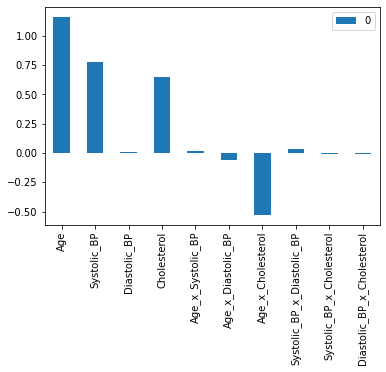

In [28]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

You may notice that Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease. You also may notice that the interaction of Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

To understand the effect of interaction terms, let's compare the output of the model we've trained on sample cases with and without the interaction. Run the cell below to choose an index and look at the features corresponding to that case in the training set. 

In [29]:
index = index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [30]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [31]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.9448
Output without interaction: 	0.9965


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


We see that the model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term). With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.